In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from torch import Tensor
from typing import Tuple, Callable
from itertools import chain
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler
from torch.distributions import MultivariateNormal

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

scaler = GradScaler(device)

Using cuda device


/tmp/ipykernel_15395/3266725043.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(device)


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    # download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    # download=True,
    transform=ToTensor(),
)

In [4]:
target_label = 0
training_data_incides = torch.where(training_data.targets == target_label)[0]
test_data_incides = torch.where(test_data.targets == target_label)[0]

training_data = Subset(training_data, training_data_incides)
test_data = Subset(test_data, test_data_incides)

In [5]:
# Define validation split fraction
val_fraction = 0.1
dataset_size = len(training_data)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

# Create a reproducible shuffled list of indices
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(dataset_size, generator=generator).tolist()

# Split indices for train and validation
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap Subsets for train and validation datasets
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

In [6]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
Training batches: 47
Test batches: 8


$$
z_B = \exp\left(-s(z_A)\right) \odot \left(x_B - b(z_A)\right)  
$$

$$
J = 
\begin{bmatrix}
I_d & 0 \\
\frac{\partial z_B}{\partial x_A} & \mathrm{diag}\big(\exp(-s)\big)
\end{bmatrix}
$$

$$
x_B = \exp\big(s(z_A, w)\big) \odot z_B + b(z_A, w)
$$

In [7]:
class CouplingLayer(nn.Module):
    def __init__(
        self,
        split_at: int,
        scale_net: nn.Module, # s
        shift_net: nn.Module, # b
        alternate_parts: bool = False
    ) -> None:
        super().__init__()
        self.split_at = split_at
        self.scale_net = scale_net
        self.shift_net = shift_net
        self.alternate_parts = alternate_parts
    

    def _split(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        if self.alternate_parts:
            return x[:, self.split_at:], x[:, :self.split_at]
        else:
            return x[:, :self.split_at], x[:, self.split_at:]


    def _merge(self, xA: Tensor, xB: Tensor) -> Tensor:
        if self.alternate_parts:
            return torch.cat((xB, xA), dim=1)
        else:
            return torch.cat((xA, xB), dim=1)


    def _get_scale_and_shift(self, zA: Tensor) -> Tuple[Tensor, Tensor]:
        log_scale = self.scale_net(zA)
        log_scale = torch.clamp(log_scale, min=-5, max=3)
        shift = self.shift_net(zA)
        return log_scale, shift


    def forward(self, x: Tensor, log_det_total: Tensor) -> Tuple[Tensor, Tensor]:
        xA, xB = self._split(x)
        zA = xA
        log_scale, shift = self._get_scale_and_shift(zA)

        zB = torch.exp(-log_scale) * (xB - shift)
        z = self._merge(zA, zB)

        log_det_current = -torch.sum(log_scale, dim=1)
        log_det_total = log_det_total + log_det_current
        return z, log_det_total


    def inverse(self, z: Tensor) -> Tensor:
        zA, zB = self._split(z)
        xA = zA
        log_scale, shift = self._get_scale_and_shift(zA)

        xB = torch.exp(log_scale) * zB + shift
        x = self._merge(xA, xB)
        return x

In [8]:
class MLP(nn.Module):
    def __init__(self,
        layers_dims: list,
        activation_layer: nn.Module = nn.ReLU(),
        bias: bool = True,
        device=None,
        dtype=None,
    ) -> None:
        super().__init__()
        assert len(layers_dims) > 2
        layers = []
        
        for in_features, out_features in zip(layers_dims[:-2], layers_dims[1:-1]):
            layers.append(nn.Linear(in_features, out_features, bias=bias, device=device, dtype=dtype))
            layers.append(copy.deepcopy(activation_layer))
        
        layers.append(nn.Linear(layers_dims[-2], layers_dims[-1], bias=bias, device=device, dtype=dtype))

        # Init last layer to small values for stability
        nn.init.zeros_(layers[-1].weight)
        if bias:
            nn.init.zeros_(layers[-1].bias)
            
        self.model = nn.Sequential(*layers)
        

    def forward(self, x) -> Tensor:
        return self.model(x)
        

In [9]:
class LambdaLayer(nn.Module):
    def __init__(
        self,
        func: Callable[[Tensor], Tensor],
        inv_func: Callable[[Tensor], Tensor],
    ) -> None:
        super().__init__()
        self.func = func
        self.inv_func = inv_func

    def forward(self, x: Tensor, *args, **kwargs):
        y = self.func(x)
        if args or kwargs:
            return (y, *args) if not kwargs else (y, *args, kwargs)
        return y
    
    def inverse(self, x: Tensor) -> Tensor:
        return self.inv_func(x)


def vec_to_img(x: Tensor) -> Tensor:
    return x.view(-1, 28, 28)

def img_to_vec(x: Tensor) -> Tensor:
    return x.flatten(1)


def sigmoid_inverse(x: Tensor):
    # Avoid log(0)
    x = torch.clamp(x, 1e-6, 1 - 1e-6)
    x = torch.log(x) - torch.log(1 - x)
    return x

def add_noise(x: Tensor):
    # Add uniform noise for dequantization (important for discrete data)
    return x + torch.rand_like(x) / 256.0


In [10]:
class FlowSequential(nn.Module):
    def __init__(self, data_dim: int, layers: nn.Module):
        super().__init__()
        self.layers = nn.ModuleList(layers)

        # Check if all modules implement required interface
        for i, module in enumerate(self.layers):
            if not hasattr(module, 'forward') or not hasattr(module, 'inverse'):
                raise TypeError(f"Module at index {i} must implement both 'forward' and 'inverse' methods.")
            
        self.register_buffer('base_mean', torch.zeros(data_dim))
        self.register_buffer('base_cov', torch.eye(data_dim))

    def forward(
        self,
        x: torch.Tensor,
        log_det: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if log_det is None:
            log_det = torch.zeros(len(x), device=x.device)
        for module in self.layers:
            x, log_det = module(x, log_det)
        return x, log_det

    def inverse(self, z: torch.Tensor) -> torch.Tensor:
        for module in reversed(self.layers):
            z = module.inverse(z)
        return z
    
    def __call__(
        self,
        x: torch.Tensor,
        log_det: torch.Tensor = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Optional: put extra logic here before/after forward
        return self.forward(x, log_det)
    
    def sample(self, num_samples: int, device:str=device) -> Tensor:
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        z = base_dist.sample((num_samples,)).to(device)
        
        # Transform through inverse flow
        with torch.no_grad():
            x = self.inverse(z)
        
        return x
    
    def log_prob(self, x: Tensor):
        z, log_det = self.forward(x)
        
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        log_prob_base = base_dist.log_prob(z)
        
        log_prob = log_prob_base + log_det
        return log_prob

In [11]:
# For implementation challange
NORMAL_DIST_CONST = torch.log(torch.tensor(2 * torch.pi, device=device))
def normal_NLL(X: Tensor) -> Tensor:
    """Compute -log p(z) for standard Gaussian"""
    d = X.shape[1]
    const_term = (d / 2) * NORMAL_DIST_CONST.to(X.device)
    squared_term = 0.5 * X.pow(2).sum(dim=1)
    return const_term + squared_term


def flow_NLL_loss(
    z_sample: Tensor,
    total_log_det: Tensor,
) -> Tensor:
    """Flow loss = base NLL - total log det (averaged)"""
    return torch.mean(normal_NLL(z_sample) - total_log_det)

In [12]:
def run_epoch(
        model: nn.Module,
        data_loader: DataLoader,
        device: str,
        optimizer,
        training_mode: bool = True,
    ) -> float:
    """
    Run a single epoch in either training or evaluation mode.
    
    Args:
        model: The model to train/evaluate
        dataloader: DataLoader for the dataset
        device: Device to run on (cuda/cpu)
        optimizer: Optimizer for training (required if train_mode=True)
        train_mode: If True, run in training mode; if False, run in evaluation mode
        max_grad_norm: Maximum gradient norm for clipping (only used in training)
    
    Returns:
        average_loss: Average loss for the epoch
    """
    total_loss, num_batches = 0, 0
    
    for data, _ in tqdm(data_loader, total=len(data_loader)):
        data = data.to(device)
        if training_mode:
            optimizer.zero_grad()
        
        # Compute negative log likelihood
        log_prob = model.log_prob(data)
        loss = -log_prob.mean()
        
        if training_mode:
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss
    

In [13]:
def save_model_with_train_state(
    checkpoint_path: str,
    model: nn.Module,
    epoch: int,
    optimizer,
    scheduler,
    train_avg_loss: float,
    val_avg_loss: float,
    train_losses: list,
    val_losses: list,
):
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_avg_loss,
        'val_loss': val_avg_loss,
        'train_losses': train_losses,
        'val_losses': val_losses
    }, checkpoint_path)


def load_best_model(
        model: nn.Module,
        checkpoint_path: str,
        device: str
) -> nn.Module:
    """
    Load the best saved model from checkpoint.
    
    Args:
        model: The model architecture (should match the saved model)
        checkpoint_path: Path to the saved checkpoint
        device: Device to load the model on
        
    Returns:
        The loaded model
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss: {checkpoint['val_loss']:.4f}")
    
    return model

In [14]:
def visualize_samples(model, device, epoch=None):
    """Generate and visualize samples from the trained model"""
    # Sample
    model.eval()
    samples = model.sample(16, device).cpu()
    samples = torch.clamp(samples, 0, 1)
    
    # Plot samples
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    
    title = f'Generated Samples - Epoch {epoch}' if epoch else 'Generated Samples'
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    model.train()


In [15]:
def train_flow(
        model: nn.Module,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        device: str,
        num_epochs: int = 50,
        lr: float = 1e-4,
        patience: int = 10,
        save_path: str = "../models/best_model.pth"
    ) -> Tuple[list, list]:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_avg_loss = run_epoch(
            model, train_dataloader, device, optimizer, True)

        
        model.eval()
        with torch.no_grad():
            val_avg_loss = run_epoch(
                model, val_dataloader, device, optimizer, False)
        
        scheduler.step()
        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)


        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0

            save_model_with_train_state(
                save_path, model, epoch, optimizer, scheduler,
                train_avg_loss, val_avg_loss, train_losses, val_losses,
            )
            
            print(f'Epoch {epoch+1} completed. Train Loss: {train_avg_loss:.4f}, '
                  f'Val Loss: {val_avg_loss:.4f} # NEW BEST MODEL #')
        else:
            epochs_without_improvement += 1
            print(f'Epoch {epoch+1} completed. Train Loss: {train_avg_loss:.4f}, '
                  f'Val Loss: {val_avg_loss:.4f} (Best: {best_val_loss:.4f} at epoch {best_epoch})')
        

        if (epoch + 1) % 10 == 0:
            visualize_samples(model, device, epoch+1)

        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f'\nEarly stopping triggered after {patience} epochs without improvement.')
            print(f'Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}')
            break

    return train_losses, val_losses

In [16]:
flow_net = FlowSequential(
    784,
    [
        LambdaLayer(img_to_vec, vec_to_img),
        LambdaLayer(add_noise, lambda x: x),
        LambdaLayer(sigmoid_inverse, torch.sigmoid),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
    ]

).to(device)


In [17]:
# Test
x_sample = next(iter(train_dataloader))[0].to(device)
x_to_z = flow_net(x_sample, 0)

100%|██████████| 5/5 [00:00<00:00, 104.65it/s]


Epoch 1 completed. Train Loss: 2541.6525, Val Loss: 1599.7394 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 113.28it/s]


Epoch 2 completed. Train Loss: 1513.6798, Val Loss: 1430.8487 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 109.16it/s]


Epoch 3 completed. Train Loss: 1382.1923, Val Loss: 1334.5827 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 114.14it/s]


Epoch 4 completed. Train Loss: 1311.0702, Val Loss: 1295.4170 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 105.17it/s]


Epoch 5 completed. Train Loss: 1267.9397, Val Loss: 1254.5631 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 81.59it/s]


Epoch 6 completed. Train Loss: 1234.8137, Val Loss: 1218.3611 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 100.21it/s]


Epoch 7 completed. Train Loss: 1210.7461, Val Loss: 1205.0138 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 105.85it/s]


Epoch 8 completed. Train Loss: 1195.0048, Val Loss: 1185.3604 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 84.28it/s]


Epoch 9 completed. Train Loss: 1177.1250, Val Loss: 1166.8504 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.41it/s]


Epoch 10 completed. Train Loss: 1162.6787, Val Loss: 1149.7440 # NEW BEST MODEL #


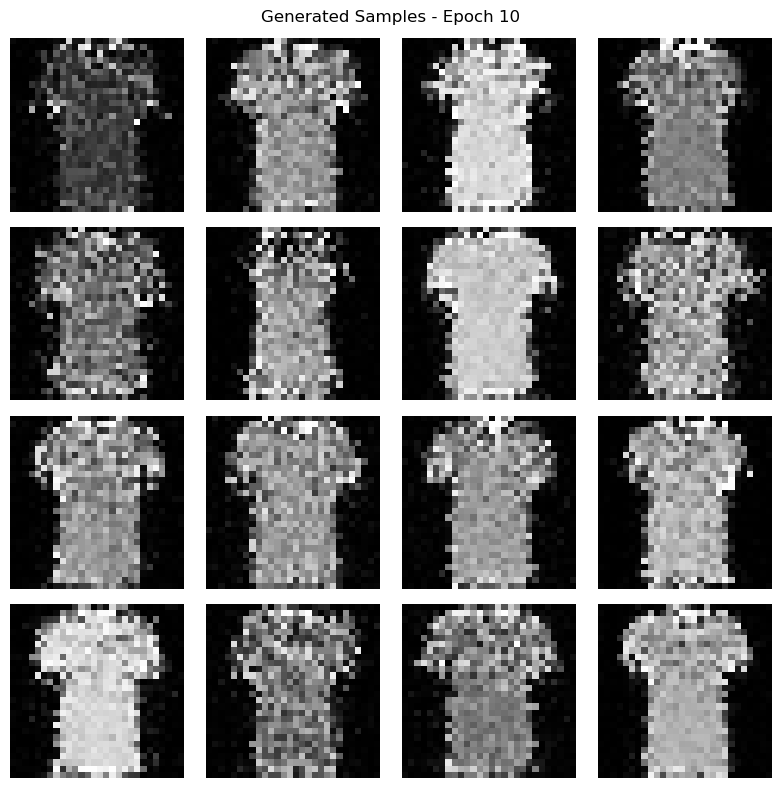

100%|██████████| 5/5 [00:00<00:00, 84.21it/s]


Epoch 11 completed. Train Loss: 1150.0296, Val Loss: 1145.3648 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 108.18it/s]


Epoch 12 completed. Train Loss: 1136.2422, Val Loss: 1125.5825 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 100.51it/s]


Epoch 13 completed. Train Loss: 1124.6887, Val Loss: 1115.5738 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 108.66it/s]


Epoch 14 completed. Train Loss: 1114.7772, Val Loss: 1107.4660 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 113.84it/s]


Epoch 15 completed. Train Loss: 1103.7401, Val Loss: 1097.5483 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 100.90it/s]


Epoch 16 completed. Train Loss: 1096.2682, Val Loss: 1082.9948 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.64it/s]


Epoch 17 completed. Train Loss: 1085.6097, Val Loss: 1076.3164 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 93.81it/s]


Epoch 18 completed. Train Loss: 1078.0773, Val Loss: 1067.5537 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 106.96it/s]


Epoch 19 completed. Train Loss: 1068.6878, Val Loss: 1062.7094 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 99.66it/s]


Epoch 20 completed. Train Loss: 1060.1346, Val Loss: 1053.6855 # NEW BEST MODEL #


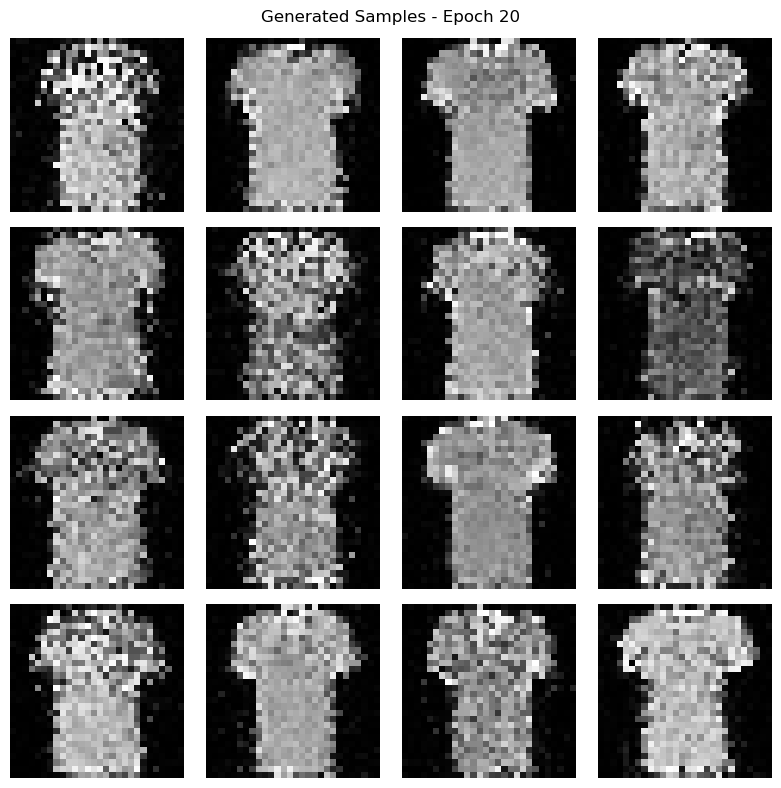

100%|██████████| 5/5 [00:00<00:00, 102.21it/s]


Epoch 21 completed. Train Loss: 1044.6690, Val Loss: 1039.6356 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 106.57it/s]


Epoch 22 completed. Train Loss: 1038.4442, Val Loss: 1034.3968 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 111.68it/s]


Epoch 23 completed. Train Loss: 1033.7072, Val Loss: 1027.7217 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 98.90it/s]


Epoch 24 completed. Train Loss: 1028.6437, Val Loss: 1025.3548 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 113.05it/s]


Epoch 25 completed. Train Loss: 1023.4642, Val Loss: 1020.0231 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 107.03it/s]


Epoch 26 completed. Train Loss: 1018.7756, Val Loss: 1015.0185 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 109.52it/s]


Epoch 27 completed. Train Loss: 1015.5290, Val Loss: 1007.1245 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 109.62it/s]


Epoch 28 completed. Train Loss: 1009.9046, Val Loss: 1007.3844 (Best: 1007.1245 at epoch 27)


100%|██████████| 5/5 [00:00<00:00, 104.25it/s]


Epoch 29 completed. Train Loss: 1005.6007, Val Loss: 1002.5950 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 106.83it/s]


Epoch 30 completed. Train Loss: 1002.4265, Val Loss: 999.3025 # NEW BEST MODEL #


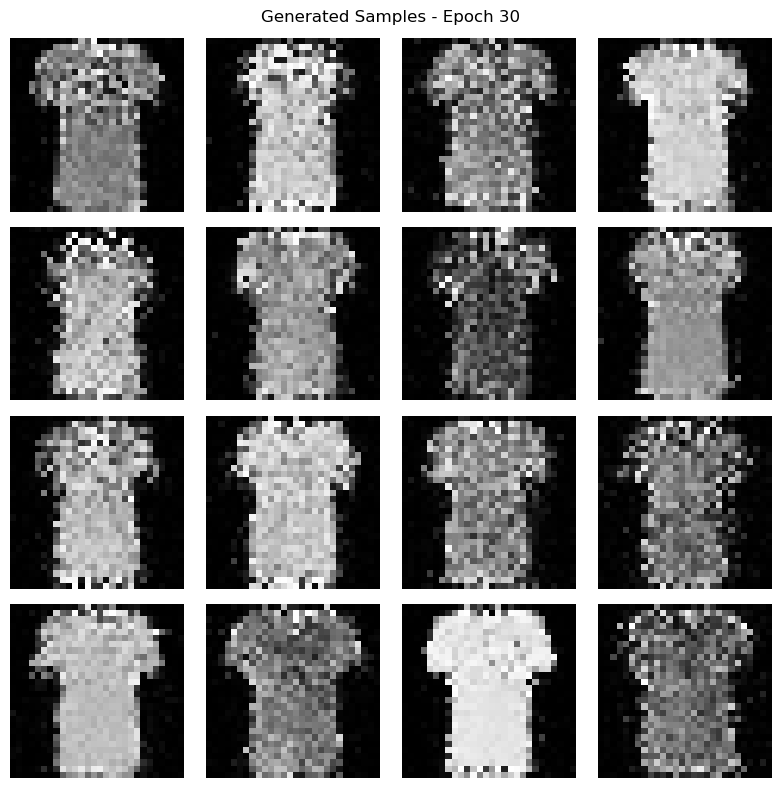

100%|██████████| 5/5 [00:00<00:00, 104.56it/s]


Epoch 31 completed. Train Loss: 996.9014, Val Loss: 994.4378 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 108.91it/s]


Epoch 32 completed. Train Loss: 993.5872, Val Loss: 988.0095 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 112.90it/s]


Epoch 33 completed. Train Loss: 990.1934, Val Loss: 987.4111 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.91it/s]


Epoch 34 completed. Train Loss: 986.1876, Val Loss: 983.6554 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 103.69it/s]


Epoch 35 completed. Train Loss: 983.0813, Val Loss: 979.5218 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 115.45it/s]


Epoch 36 completed. Train Loss: 980.7290, Val Loss: 977.2243 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.00it/s]


Epoch 37 completed. Train Loss: 976.7205, Val Loss: 969.7215 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 120.34it/s]


Epoch 38 completed. Train Loss: 973.7416, Val Loss: 968.1954 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 98.30it/s]


Epoch 39 completed. Train Loss: 969.8541, Val Loss: 964.8706 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 96.50it/s]


Epoch 40 completed. Train Loss: 966.8995, Val Loss: 959.2779 # NEW BEST MODEL #


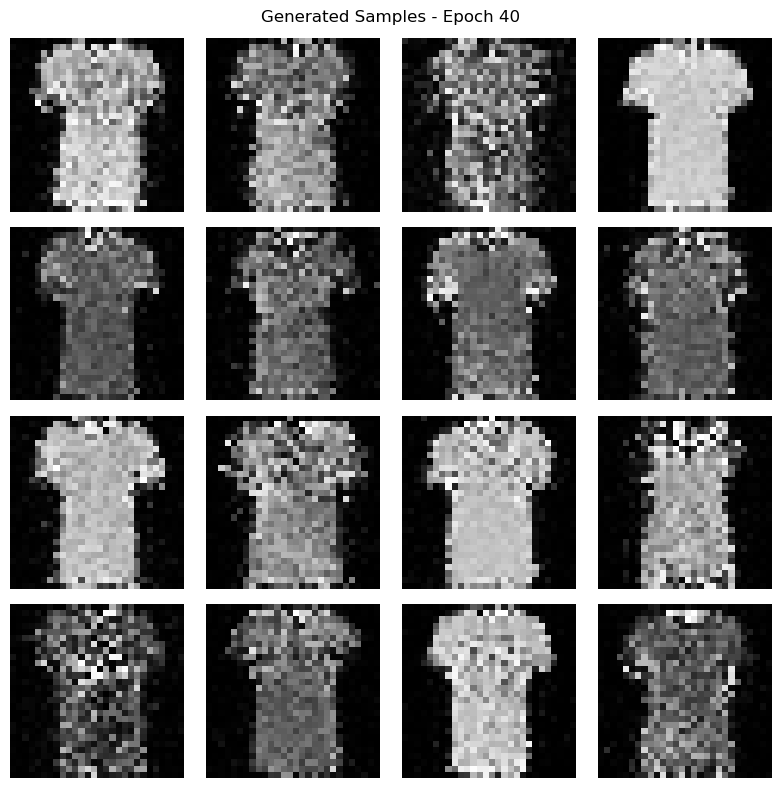

100%|██████████| 5/5 [00:00<00:00, 111.08it/s]


Epoch 41 completed. Train Loss: 958.3186, Val Loss: 954.7911 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 116.04it/s]


Epoch 42 completed. Train Loss: 956.0740, Val Loss: 953.7723 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 105.55it/s]


Epoch 43 completed. Train Loss: 954.3353, Val Loss: 949.8306 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 105.73it/s]


Epoch 44 completed. Train Loss: 951.1530, Val Loss: 947.2856 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 111.01it/s]


Epoch 45 completed. Train Loss: 950.2247, Val Loss: 946.3918 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 107.79it/s]


Epoch 46 completed. Train Loss: 947.9194, Val Loss: 945.5851 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 99.54it/s]


Epoch 47 completed. Train Loss: 945.7108, Val Loss: 943.5310 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 115.36it/s]


Epoch 48 completed. Train Loss: 943.7712, Val Loss: 943.8344 (Best: 943.5310 at epoch 47)


100%|██████████| 5/5 [00:00<00:00, 110.71it/s]


Epoch 49 completed. Train Loss: 942.1759, Val Loss: 940.2547 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 109.63it/s]


Epoch 50 completed. Train Loss: 941.1618, Val Loss: 937.3839 # NEW BEST MODEL #


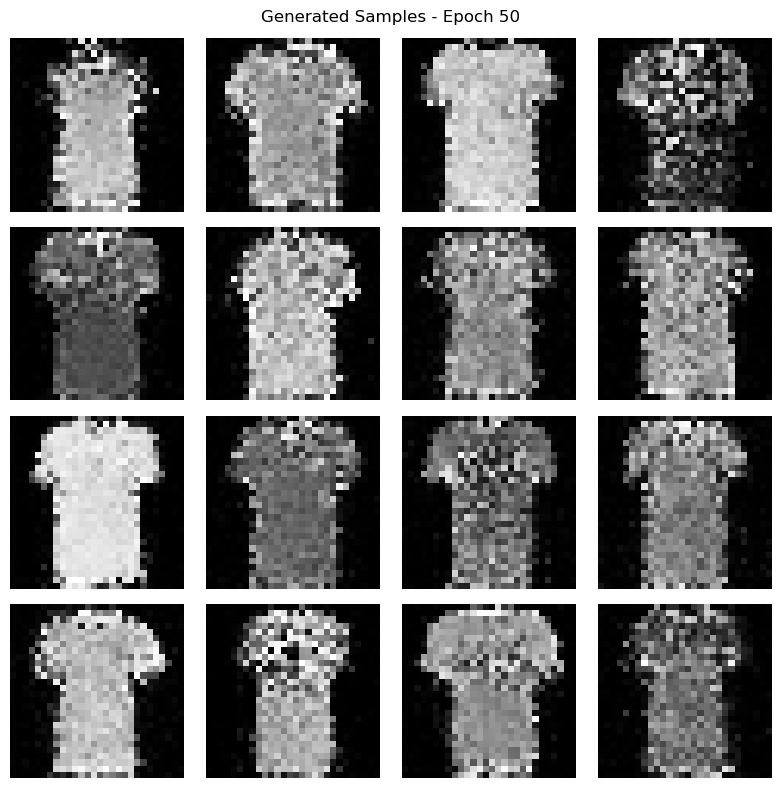

100%|██████████| 5/5 [00:00<00:00, 107.60it/s]


Epoch 51 completed. Train Loss: 938.7687, Val Loss: 936.5617 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.94it/s]


Epoch 52 completed. Train Loss: 936.6359, Val Loss: 933.8660 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 100.78it/s]


Epoch 53 completed. Train Loss: 935.4851, Val Loss: 929.0361 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.45it/s]


Epoch 54 completed. Train Loss: 933.0258, Val Loss: 932.7590 (Best: 929.0361 at epoch 53)


100%|██████████| 5/5 [00:00<00:00, 110.67it/s]


Epoch 55 completed. Train Loss: 931.9022, Val Loss: 929.1610 (Best: 929.0361 at epoch 53)


100%|██████████| 5/5 [00:00<00:00, 107.46it/s]


Epoch 56 completed. Train Loss: 929.3603, Val Loss: 926.7478 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 111.17it/s]


Epoch 57 completed. Train Loss: 927.7819, Val Loss: 926.6328 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.05it/s]


Epoch 58 completed. Train Loss: 926.2603, Val Loss: 924.4682 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.66it/s]


Epoch 59 completed. Train Loss: 925.5420, Val Loss: 921.5842 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 109.63it/s]


Epoch 60 completed. Train Loss: 923.8941, Val Loss: 921.1891 # NEW BEST MODEL #


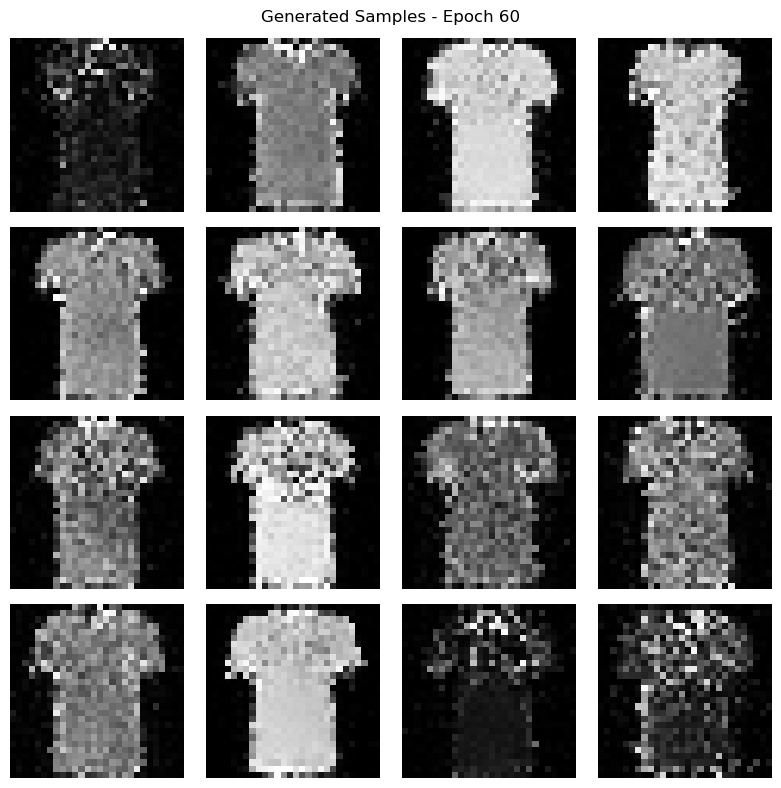

100%|██████████| 5/5 [00:00<00:00, 99.50it/s]


Epoch 61 completed. Train Loss: 919.9937, Val Loss: 915.3653 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 111.01it/s]


Epoch 62 completed. Train Loss: 918.6167, Val Loss: 914.2858 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.65it/s]


Epoch 63 completed. Train Loss: 916.9591, Val Loss: 914.3513 (Best: 914.2858 at epoch 62)


100%|██████████| 5/5 [00:00<00:00, 105.58it/s]


Epoch 64 completed. Train Loss: 915.8075, Val Loss: 913.4310 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 113.84it/s]


Epoch 65 completed. Train Loss: 915.2427, Val Loss: 911.7400 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 109.93it/s]


Epoch 66 completed. Train Loss: 914.5593, Val Loss: 912.6992 (Best: 911.7400 at epoch 65)


100%|██████████| 5/5 [00:00<00:00, 102.84it/s]


Epoch 67 completed. Train Loss: 912.7901, Val Loss: 909.5810 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 104.47it/s]


Epoch 68 completed. Train Loss: 912.4629, Val Loss: 909.3035 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 106.63it/s]


Epoch 69 completed. Train Loss: 911.0630, Val Loss: 910.2503 (Best: 909.3035 at epoch 68)


100%|██████████| 5/5 [00:00<00:00, 103.15it/s]


Epoch 70 completed. Train Loss: 910.7412, Val Loss: 906.7259 # NEW BEST MODEL #


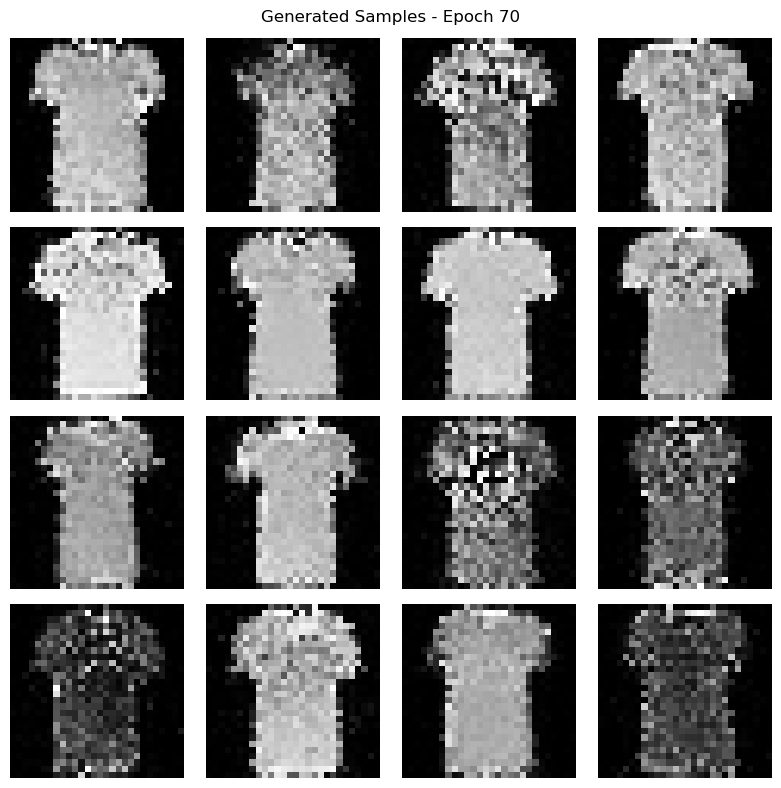

100%|██████████| 5/5 [00:00<00:00, 110.39it/s]


Epoch 71 completed. Train Loss: 909.7573, Val Loss: 905.4129 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 107.27it/s]


Epoch 72 completed. Train Loss: 908.6889, Val Loss: 906.9231 (Best: 905.4129 at epoch 71)


100%|██████████| 5/5 [00:00<00:00, 111.75it/s]


Epoch 73 completed. Train Loss: 908.0950, Val Loss: 905.6715 (Best: 905.4129 at epoch 71)


100%|██████████| 5/5 [00:00<00:00, 112.29it/s]


Epoch 74 completed. Train Loss: 907.5321, Val Loss: 902.6384 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 107.89it/s]


Epoch 75 completed. Train Loss: 906.2564, Val Loss: 902.5496 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 115.78it/s]


Epoch 76 completed. Train Loss: 905.2437, Val Loss: 903.2216 (Best: 902.5496 at epoch 75)


100%|██████████| 5/5 [00:00<00:00, 101.32it/s]


Epoch 77 completed. Train Loss: 904.6879, Val Loss: 902.5400 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 106.51it/s]


Epoch 78 completed. Train Loss: 904.1860, Val Loss: 900.2681 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 114.60it/s]


Epoch 79 completed. Train Loss: 903.0899, Val Loss: 899.2137 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.37it/s]


Epoch 80 completed. Train Loss: 902.2482, Val Loss: 899.9018 (Best: 899.2137 at epoch 79)


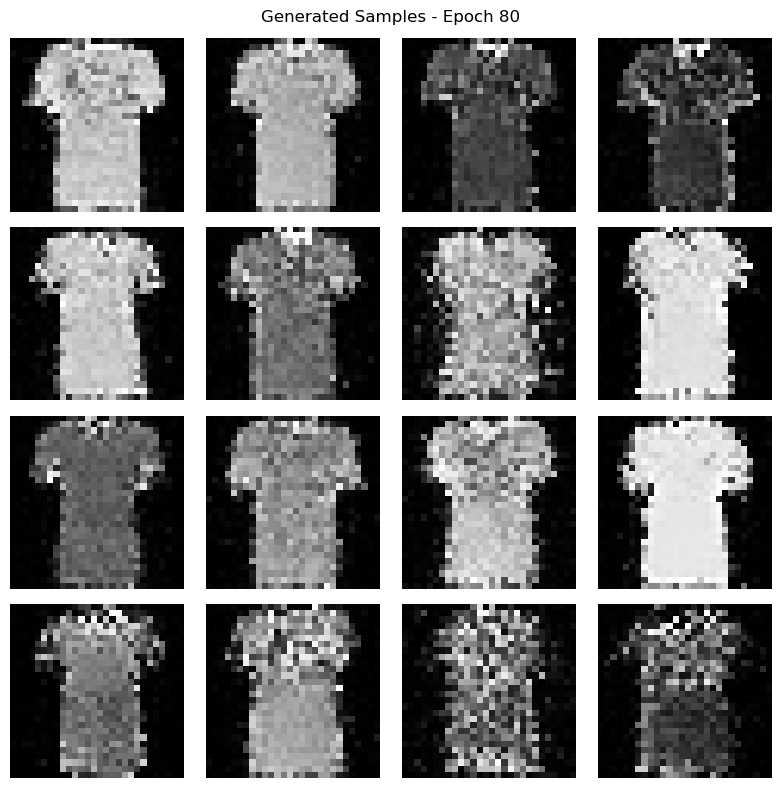

100%|██████████| 5/5 [00:00<00:00, 101.26it/s]


Epoch 81 completed. Train Loss: 899.9998, Val Loss: 897.4286 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 110.16it/s]


Epoch 82 completed. Train Loss: 899.2479, Val Loss: 897.1920 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 115.56it/s]


Epoch 83 completed. Train Loss: 898.3143, Val Loss: 895.6731 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 104.45it/s]


Epoch 84 completed. Train Loss: 898.0267, Val Loss: 897.5557 (Best: 895.6731 at epoch 83)


100%|██████████| 5/5 [00:00<00:00, 103.91it/s]


Epoch 85 completed. Train Loss: 898.5756, Val Loss: 896.2833 (Best: 895.6731 at epoch 83)


100%|██████████| 5/5 [00:00<00:00, 107.02it/s]


Epoch 86 completed. Train Loss: 897.2961, Val Loss: 895.2134 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 105.39it/s]


Epoch 87 completed. Train Loss: 896.5093, Val Loss: 892.4206 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 111.12it/s]


Epoch 88 completed. Train Loss: 896.4806, Val Loss: 895.3633 (Best: 892.4206 at epoch 87)


100%|██████████| 5/5 [00:00<00:00, 112.85it/s]


Epoch 89 completed. Train Loss: 895.8206, Val Loss: 893.6267 (Best: 892.4206 at epoch 87)


100%|██████████| 5/5 [00:00<00:00, 107.92it/s]


Epoch 90 completed. Train Loss: 895.5958, Val Loss: 893.8806 (Best: 892.4206 at epoch 87)


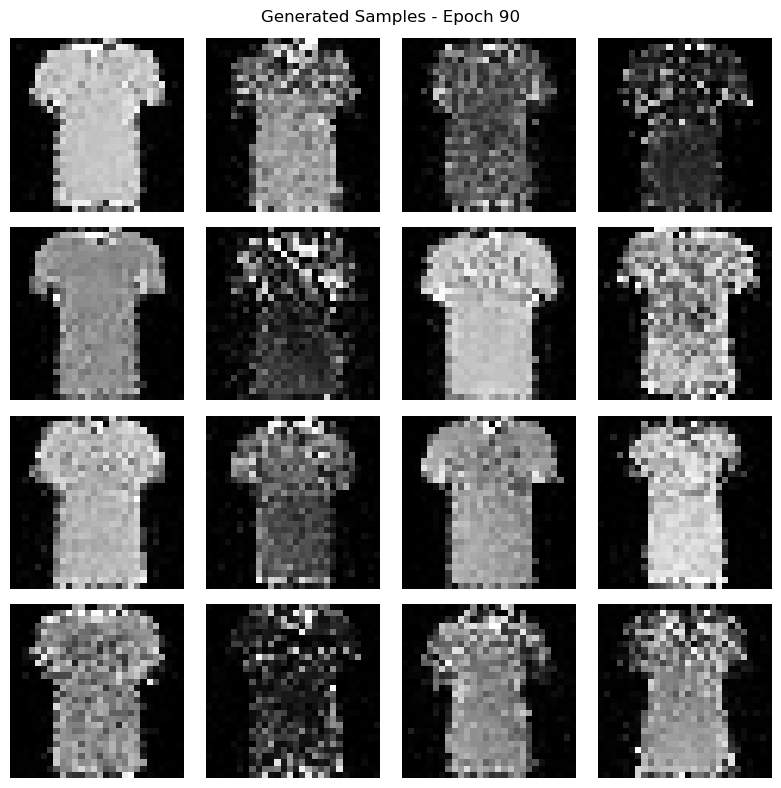

100%|██████████| 5/5 [00:00<00:00, 110.45it/s]


Epoch 91 completed. Train Loss: 895.5113, Val Loss: 892.1191 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 107.81it/s]


Epoch 92 completed. Train Loss: 894.9104, Val Loss: 890.0036 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 113.20it/s]


Epoch 93 completed. Train Loss: 894.0894, Val Loss: 892.2238 (Best: 890.0036 at epoch 92)


100%|██████████| 5/5 [00:00<00:00, 102.05it/s]


Epoch 94 completed. Train Loss: 893.9859, Val Loss: 890.0228 (Best: 890.0036 at epoch 92)


100%|██████████| 5/5 [00:00<00:00, 111.45it/s]


Epoch 95 completed. Train Loss: 892.2323, Val Loss: 890.0680 (Best: 890.0036 at epoch 92)


100%|██████████| 5/5 [00:00<00:00, 114.36it/s]


Epoch 96 completed. Train Loss: 893.0040, Val Loss: 890.9343 (Best: 890.0036 at epoch 92)


100%|██████████| 5/5 [00:00<00:00, 109.27it/s]


Epoch 97 completed. Train Loss: 892.4655, Val Loss: 889.1259 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 108.00it/s]


Epoch 98 completed. Train Loss: 891.9427, Val Loss: 888.7568 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 107.87it/s]


Epoch 99 completed. Train Loss: 891.2586, Val Loss: 888.3934 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 108.21it/s]


Epoch 100 completed. Train Loss: 891.1418, Val Loss: 887.8459 # NEW BEST MODEL #


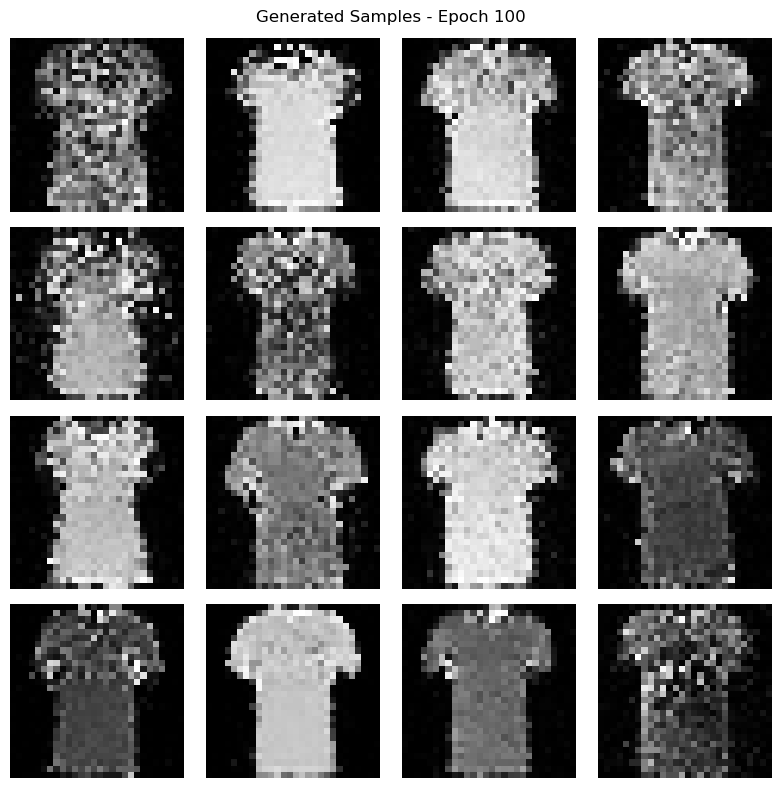

In [18]:
model_save_path = '../models/coupling_model.pth'
train_losses, val_losses = train_flow(
    flow_net, train_dataloader, val_dataloader, device,
    num_epochs=100, lr=1e-4, save_path=model_save_path)

In [19]:
def plot_losses(train_losses: list, val_losses: list):
    """
    Plots training and validation loss curves.

    Args:
        train_losses (List[float]): Training loss values per epoch.
        val_losses (List[float]): Validation loss values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

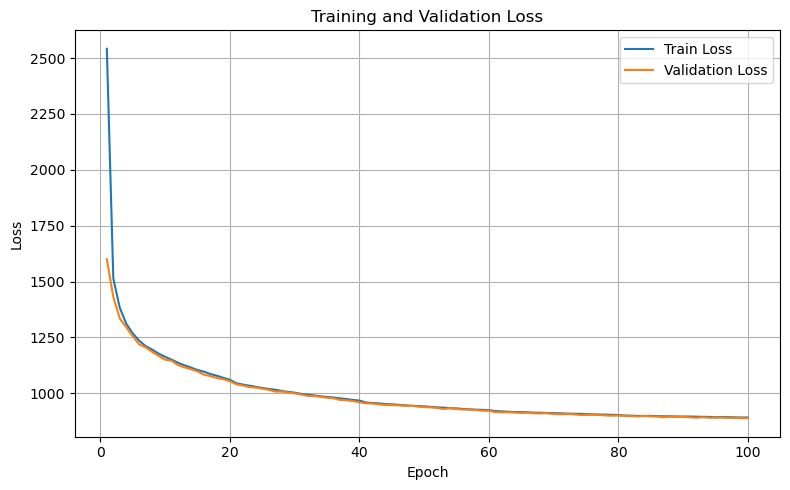

In [20]:
plot_losses(train_losses, val_losses)

In [21]:
# Test reconstruction quality
def test_reconstruction(
    model: nn.modules,
    test_dataloader: DataLoader,
    device: str,
    num_samples: int = 8
):
    """Test how well the model can reconstruct real data"""
    model.eval()
    with torch.no_grad():
        # Get a batch of real data
        real_data, _ = next(iter(test_dataloader))
        real_data = real_data[:num_samples].to(device)
        
        # Forward pass to latent space
        z, _ = model.forward(real_data)
        
        # Reconstruct
        reconstructed = model.inverse(z)
        
        # Convert back to images
        real_images = real_data.squeeze(1).cpu()
        reconstructed_images = reconstructed.cpu()
        
        # Visualize
        fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))
        for i in range(num_samples):
            axes[0, i].imshow(real_images[i], cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(reconstructed_images[i], cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    model.train()


Loaded model from epoch 100 with validation loss: 887.8459


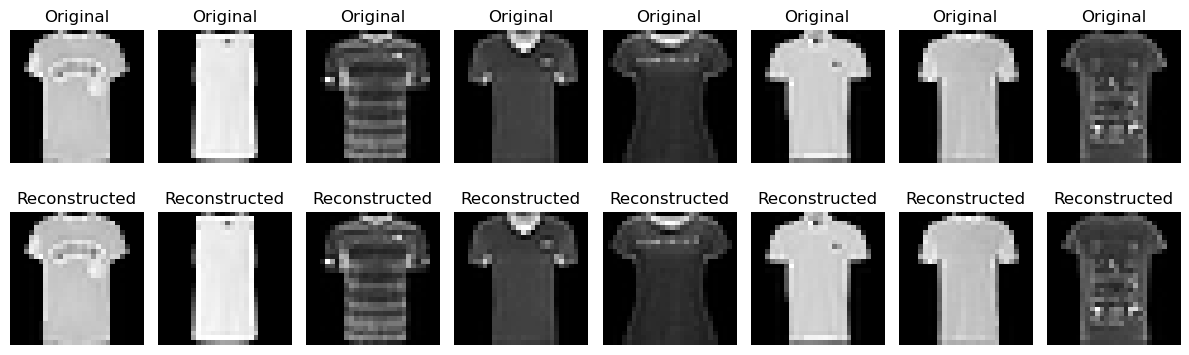

In [22]:
flow_net = load_best_model(flow_net, model_save_path, device)
test_reconstruction(flow_net, test_dataloader, device)